In [1]:
! git clone https://github.com/kulikovv/harmonic.git

Cloning into 'harmonic'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 52 (delta 1), reused 0 (delta 0), pack-reused 46
Unpacking objects: 100% (52/52), done.


In [1]:
import torch 
from torchvision import transforms

In [2]:
import numpy as np
from skimage.measure import regionprops
from sklearn.cluster import MeanShift


def cluster(embedding_result, bandwidth=0.3, semantic=None, minimal_area=20):
    """
    Cluster embeddings to separate instances
    :param embedding_result: embedding as numpy array
    :param bandwidth: the bandwidth should be equal to epsilon from fit method of embedder
    :param semantic: semantic segmentation mask (in that case each value of mask will be processed separatly)
    :param minimal_area: minimal area of instance
    :return: 
    """
    assert isinstance(embedding_result, np.ndarray), "res should be numpy ndarray"
    assert 3 == len(embedding_result.shape), "res should be [NxWxH] where N is the number of guide functions"

    x = embedding_result.reshape(embedding_result.shape[0], -1).transpose(1, 0)
    l = np.zeros(x.shape[0])

    ms = MeanShift(bandwidth=bandwidth, bin_seeding=True)

    if semantic is not None:
        inc = 1
        sem = semantic.reshape(-1)
        assert sem.shape[0] == x.shape[0], "semantic segmentation mask must be of the same size"
    else:
        inc = 0
        sem = np.ones(x.shape[0]).reshape(-1)

    for c in np.unique(sem):
        if 0 == c:
            # ignore background
            continue

        ms.fit(x[sem == c])
        l[sem == c] = ms.labels_ + np.max(l) + inc

    regions = regionprops(l.reshape(embedding_result[0].shape).astype("int32"))
    for r in regions:
        # filter small objects
        if r.area < minimal_area:
            l[l == r.label] = 0

    return l.reshape(embedding_result[0].shape)

In [3]:
import torch
import torch.nn as nn

'''
An alternative implementation for PyTorch with auto-infering the x-y dimensions.
From https://github.com/mkocabas/CoordConv-pytorch
'''


class AddCoords(nn.Module):
    def __init__(self, normalize=True):
        super(AddCoords, self).__init__()
        self.normalize = normalize

    def generate_xy(self, input_tensor):
        batch_size, _, x_dim, y_dim = input_tensor.size()

        xx_channel = torch.arange(x_dim).repeat(1, y_dim, 1)
        yy_channel = torch.arange(y_dim).repeat(1, x_dim, 1).transpose(1, 2)

        if self.normalize:
            xx_channel = xx_channel.float() / (x_dim - 1)
            yy_channel = yy_channel.float() / (y_dim - 1)

            xx_channel = xx_channel * 2 - 1
            yy_channel = yy_channel * 2 - 1

        xx_channel = xx_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)
        yy_channel = yy_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3)

        return xx_channel, yy_channel

    def forward(self, input_tensor):
        """
        Args:
            input_tensor: shape(batch, channel, x_dim, y_dim)
        """

        xx_channel, yy_channel = self.generate_xy(input_tensor)
        ret = torch.cat([
            input_tensor,
            xx_channel.type_as(input_tensor),
            yy_channel.type_as(input_tensor)], dim=1)

        return ret


class CoordConv(nn.Module):
    def __init__(self, in_channels, out_channels, sins=[], **kwargs):
        super(CoordConv, self).__init__()
        self.addcoords = AddCoords()
        in_size = in_channels + 2
        self.conv = nn.Conv2d(in_size, out_channels, **kwargs)

    def forward(self, x):
        ret = self.addcoords(x)
        ret = self.conv(ret)
        return ret

In [4]:
import torch
import torch.nn as nn
from torch.nn.parameter import Parameter

#from coordconv import CoordConv, AddCoords

'''
An alternative implementation for PyTorch with auto-infering the x-y dimensions.
'''


class AddSine(AddCoords):
    def __init__(self, alpha=0.5, beta=None, phase_shift=0.):
        super(AddSine, self).__init__(False)
        if beta is None:
            beta = alpha
        self.alpha = Parameter(torch.FloatTensor([alpha]))
        self.beta = Parameter(torch.FloatTensor([beta]))
        self.phase = Parameter(torch.FloatTensor([phase_shift]))

    def generate_xy(self, input_tensor):
        batch_size, _, x_dim, y_dim = input_tensor.size()

        sx = self.phase

        xx_channel = torch.linspace(0., 1., x_dim).repeat(1, y_dim, 1).to(self.phase.device)
        yy_channel = torch.linspace(0., 1., y_dim).repeat(1, x_dim, 1).transpose(1, 2).to(self.phase.device)

        xx_channel = xx_channel.float() * self.alpha
        yy_channel = yy_channel.float() * self.beta

        channel = xx_channel.repeat(batch_size, 1, 1, 1).transpose(2, 3) + yy_channel.repeat(batch_size, 1, 1,
                                                                                             1).transpose(2, 3)
        channel = torch.sin(channel + sx)
        return channel

    def __repr__(self):
        return self.__class__.__name__ + ' (' \
                                         "alpha=" + str(self.alpha.item()) + \
               " beta=" + str(self.beta.item()) + \
               " phase=" + str(self.phase.item()) + ")"

    def forward(self, input_tensor):
        """
        Args:
            input_tensor: shape(batch, channel, x_dim, y_dim)
        """

        xx_channel = self.generate_xy(input_tensor)
        ret = torch.cat([
            input_tensor,
            xx_channel.type_as(input_tensor)], dim=1)

        return ret


class SinConv(CoordConv):
    def __init__(self, in_channels, out_channels, sins=[], **kwargs):
        super(SinConv, self).__init__(in_channels, out_channels, **kwargs)
        self.addcoords = nn.Sequential(*[AddSine(a, b, p) for a, b, p in sins])
        in_size = in_channels + len(sins)
        self.conv = nn.Conv2d(in_size, out_channels, **kwargs)

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

#from harmonic import SinConv


class double_conv(nn.Module):
    '''(conv => BN => ReLU) * 2'''

    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x


class ups(nn.Module):
    def __init__(self, in_ch, out_ch, sins):
        super(ups, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights

        self.sinconv = SinConv(in_ch, out_ch, sins=sins, kernel_size=7, padding=3)
        self.conv = double_conv(out_ch, out_ch)

    def forward(self, x1, x2):
        #x1 = F.interpolate(x1, scale_factor=2, mode='bilinear', align_corners=True)
        x1 = F.upsample(x1, scale_factor=2, mode='bilinear', align_corners=True)
        diffX = x1.size()[2] - x2.size()[2]
        diffY = x1.size()[3] - x2.size()[3]
        x2 = F.pad(x2, (diffX // 2, int(diffX / 2),
                        diffY // 2, int(diffY / 2)))
        x = torch.cat([x2, x1], dim=1)
        x = self.sinconv(x)
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x


class outconv(nn.Module):
    def __init__(self, in_ch, out_ch, sins):
        super(outconv, self).__init__()
        self.sinconv = SinConv(in_ch, in_ch, sins=sins, kernel_size=7, padding=3)
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.sinconv(x)
        x = self.conv(x)
        return x


class UNet(nn.Module):
    def __init__(self, n_channels, sins):
        super(UNet, self).__init__()

        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = ups(1024, 256, sins)
        self.up2 = ups(512, 128, sins)
        self.up3 = ups(256, 64, sins)
        self.up4 = ups(128, 64, sins)
        self.outc = outconv(64, len(sins), sins)

    def freeze_encoder(self, freeze):
        return None

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return x

In [6]:
!wget https://www.dropbox.com/s/2qmedy70qmz76s2/cvppp_harmonic.t7 -O cvppp_harmonic.t7

--2022-04-11 12:11:54--  https://www.dropbox.com/s/2qmedy70qmz76s2/cvppp_harmonic.t7
Resolving www.dropbox.com (www.dropbox.com)... 162.125.65.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.65.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/2qmedy70qmz76s2/cvppp_harmonic.t7 [following]
--2022-04-11 12:11:55--  https://www.dropbox.com/s/raw/2qmedy70qmz76s2/cvppp_harmonic.t7
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc536adfdb4ef1d6ed6e5ad59c10.dl.dropboxusercontent.com/cd/0/inline/BjMxok179audYdGnuTDTh8LSntHqaOH4LsCZTw7LJjfHySKnH3KcIPlVjPNbDyeajcanR5IxEXUvPHLxlXysMh9-zDcoMrH6EaslVssqIQO5fBsOCS8KZwUO6zh0ERclmPmhpC9aoy-sCm58NOm0dGiMQVmfCCpK9vBO0HAmeXigFA/file# [following]
--2022-04-11 12:11:55--  https://uc536adfdb4ef1d6ed6e5ad59c10.dl.dropboxusercontent.com/cd/0/inline/BjMxok179audYdGnuTDTh8LSntHqaOH4LsCZTw7LJjfHySKnH3

In [12]:
import torch 
from torchvision import transforms

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose(
    [transforms.Resize(size=(448,448)),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.485, 0.456, 0.406],
                          std=[0.229, 0.224, 0.225])])

sins = [[-24.22295570373535, 0.0, 0.4452361464500427],
 [-14.779047012329102, 0.0, 1.2561423778533936],
 [-16.399198532104492, 0.0, -0.3734317719936371],
 [18.362571716308594, 0.0, 0.7659217715263367],
 [-0.6603534817695618, 0.0, 0.24005144834518433],
 [-33.7341423034668, 0.0, -0.4350433051586151],
 [0.0, 4.286965370178223, 0.8109257817268372],
 [0.0, -19.908288955688477, 0.614355206489563],
 [0.0, 22.987812042236328, 0.28104516863822937],
 [0.0, 7.108828067779541, 0.4827950894832611],
 [0.0, 23.66850471496582, 0.21264752745628357],
 [0.0, -22.332250595092773, 1.0007625818252563]]


net = torch.nn.DataParallel(UNet(3, sins), [0]).to(device)
wdict = torch.load('/content/cvppp_harmonic.t7')
w1dict = wdict.copy()
for k in wdict.copy().keys():
    if k.endswith('num_batches_tracked'):
        w1dict.pop(k)

net.load_state_dict(w1dict)
net.eval()
print("Model loaded")

Model loaded


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


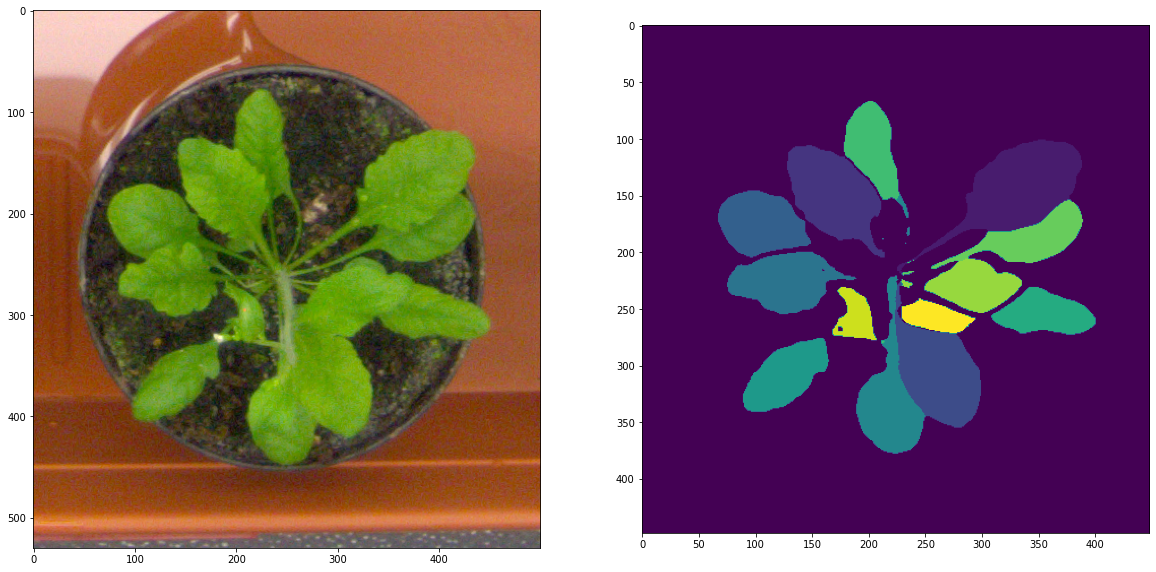

In [13]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img = Image.open("/content/plant161_rgb.png").convert('RGB')
#estimate the embeddings
emb = net(transform(img).unsqueeze(0).to(device)).detach().cpu().numpy()
#cluster embeddings space
cc = cluster(emb[0],0.5,minimal_area=1000)

f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(img)
ax[1].imshow(cc)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


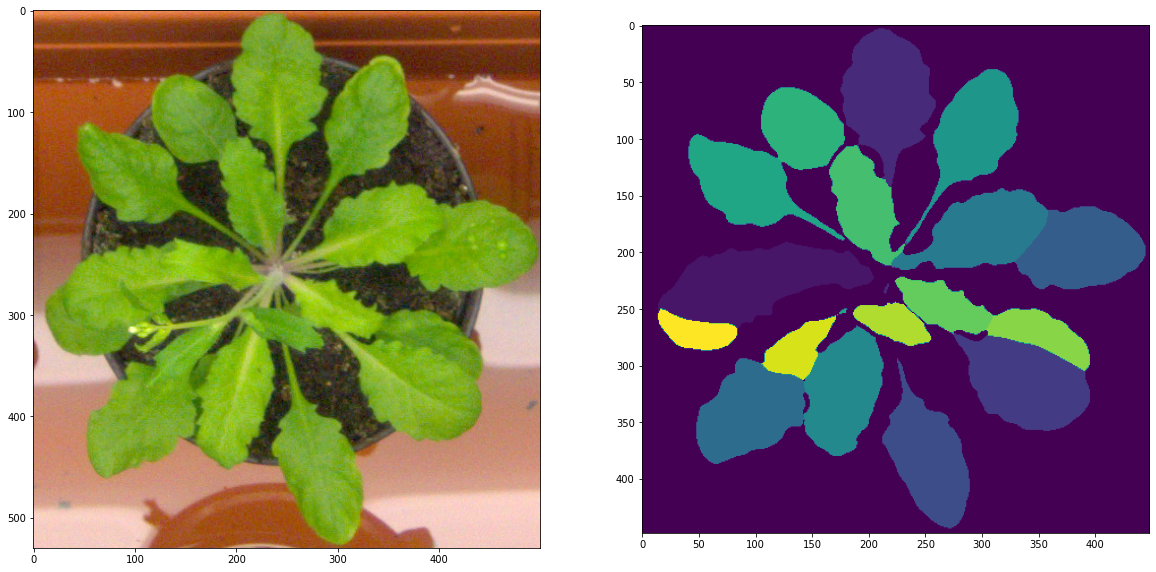

In [16]:
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

img = Image.open("/content/plant159_rgb.png").convert('RGB')
#estimate the embeddings
emb = net(transform(img).unsqueeze(0).to(device)).detach().cpu().numpy()
#cluster embeddings space
cc = cluster(emb[0],0.5,minimal_area=1000)

f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(img)
ax[1].imshow(cc)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


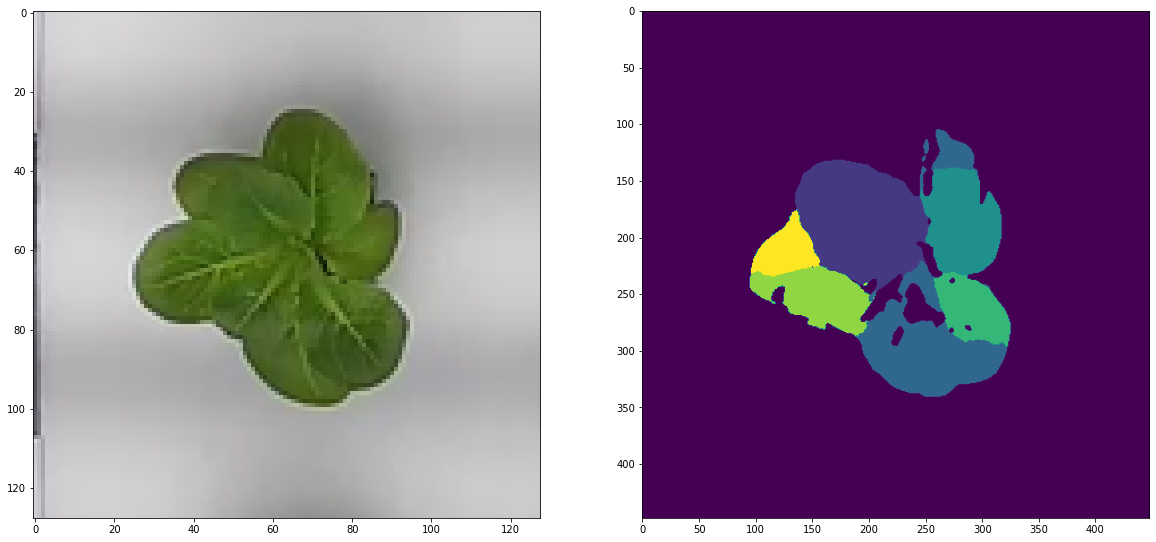

In [14]:
img = Image.open("/content/0022.png").convert('RGB')
#estimate the embeddings
emb = net(transform(img).unsqueeze(0).to(device)).detach().cpu().numpy()
#cluster embeddings space
cc = cluster(emb[0],0.5,minimal_area=1000)

f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(img)
ax[1].imshow(cc)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3509: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


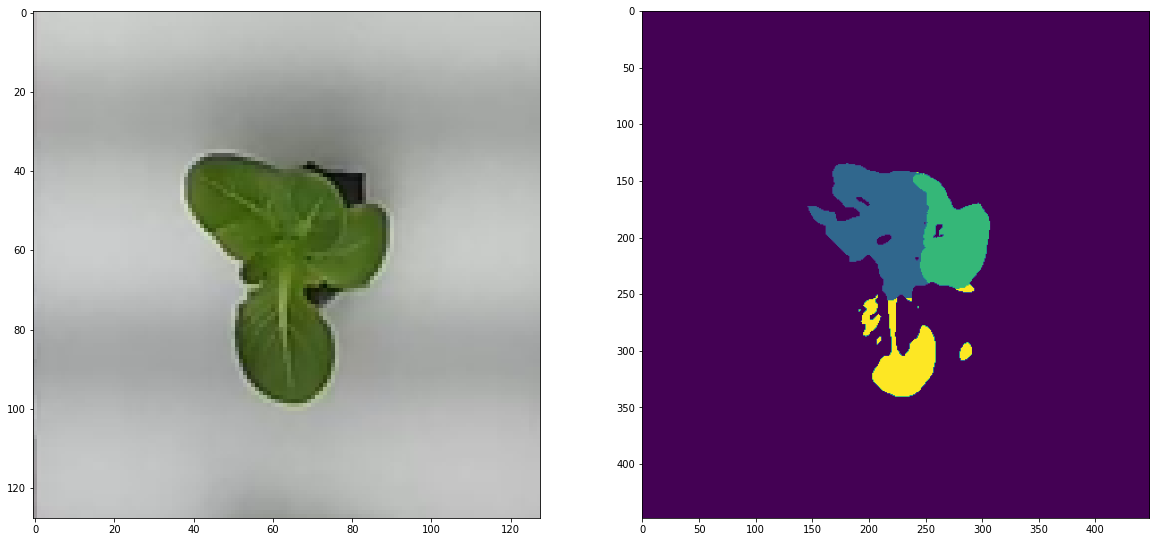

In [15]:
img = Image.open("/content/0015.png").convert('RGB')
#estimate the embeddings
emb = net(transform(img).unsqueeze(0).to(device)).detach().cpu().numpy()
#cluster embeddings space
cc = cluster(emb[0],0.5,minimal_area=1000)

f,ax = plt.subplots(nrows=1,ncols=2,figsize=(20,10))
ax[0].imshow(img)
ax[1].imshow(cc)